In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import yaml
from tqdm import tqdm

from erpe.analysis import *
from erpe.experiment_design import *
from erpe.models import *

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

In [6]:
create_XI_model_1q?

Signature:
create_XI_model_1q(
    x_vec,
    qid: str = 'Q0',
    gate_depol_rate: float = 0.0,
    spam_depol_rate: float = 0.0,
)
Docstring:
Create a single-qubit model with X and I errors.

Parameters
----------
x_vec : numpy.ndarray
    3-element array specifying the error parameters 
    (x_error, detuning, idle_phase_error

qid : str, optional
    The qubit id. Default is 'Q0'.

gate_depol_rate : float, optional
    The depolarizing error rate for the gates. Default is 0.
Returns
-------
Model
File:      ~/erpe/erpe/models.py
Type:      function

# Making phase plots 1 parameter

In [11]:
EDesign_1QXI?

Init signature: EDesign_1QXI(depths: List[int], qids: str = 'Q0')
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Init docstring:
Base class for an experiment design.

Args:
    germs (List[str]): list of germs.
    inphase_state_preps (List[str]): list of in-phase state preps.
    quadruature_state_preps (List[str]): list of quadrature state preps.
    meas_fiducial (List[str]): list of measurement fiducials.
    depths (List[int]): list of depths.
File:           ~/erpe/erpe/experiment_design.py
Type:           ABCMeta
Subclasses:     

In [27]:
depths = np.arange(100)
num_shots = 512 
qid = ['Q0']
edesign = EDesign_Ramsey(depths, qid)
model = create_XI_model_1q([0.0, 0, 0.1], qid[0], gate_depol_rate=0.01)
ds = edesign.make_dataset(model, num_shots)
analysis = Analysis_Ramsey(ds, edesign)


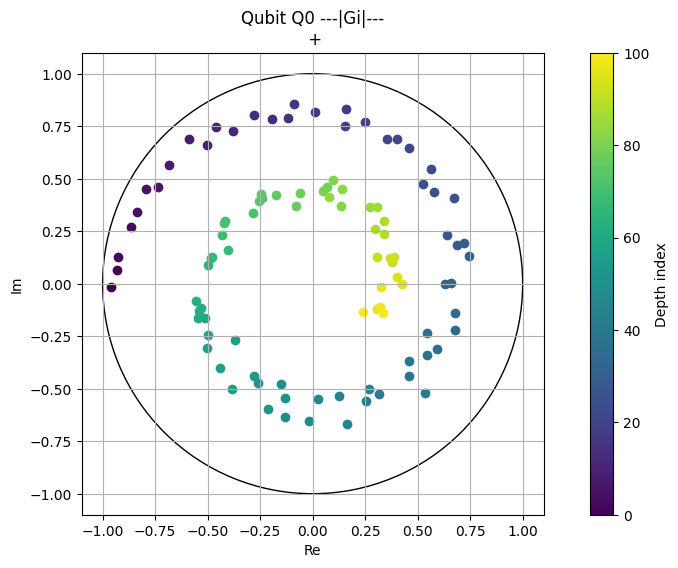

In [28]:
analysis.plot_all_signals()

In [10]:
debug

> /home/jpmarceaux/erpe/erpe/experiment_design.py(370)__init__()
    368         depths = depths
    369         line_labels = qids
--> 370         assert len(qids) == 1, "Only one qubit is allowed for this experiment design."
    371         self.qids = qids
    372         super().__init__(depths, line_labels)

512
512


### Verifying the uncertainty estimator 
$$
    \sigma_{\text{RPE}} \approx \frac{\pi}{2^{p_{\text{max}+1}} \sqrt{N}}
$$
where $N$ is num shots and $p_{\text{max}}$ is the max depth power

In [2]:
def estimate_rpe_sigma(num_shots, max_depth_power):
    return np.pi/(2*2**max_depth_power*np.sqrt(num_shots))

In [3]:
num_trials = 100
num_sample_series = [100, 1000, 10000]
max_depths = [6, 8, 10, 12]
qids = ['Q1']
all_xs = np.zeros((num_trials, len(num_sample_series), len(max_depths)))
for n in tqdm(range(num_trials)):
    for i, num_samples in enumerate(num_sample_series):
        for j, max_depth in enumerate(max_depths):
            depths = [2**i for i in range(max_depth)]
            edesign = EDesign_Xoverrot(qids=qids, depths=depths)
            model_target = create_XI_model_1q(np.zeros(3), qids[0])
            ds = edesign.make_dataset(model_target, num_samples)
            analysis = Analysis_Xoverrot(ds, edesign)
            all_xs[n, i, j] = analysis.estimates['X overrot']

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


In [4]:
sigma_estimates = np.zeros((len(num_sample_series), len(max_depths)))
for i, num_samples in enumerate(num_sample_series):
    for j, max_depth in enumerate(max_depths):
        sigma_estimates[i, j] = estimate_rpe_sigma(num_samples, max_depth)

In [5]:
all_xs_mean = np.mean(all_xs, axis=0)
all_xs_std = np.std(all_xs, axis=0)

In [6]:
all_xs_std

array([[1.86787473e-03, 4.67038988e-04, 1.15179978e-04, 3.44417174e-05],
       [6.30628309e-04, 1.56346487e-04, 3.43029037e-05, 9.31810532e-06],
       [1.96553594e-04, 4.70048223e-05, 1.19907365e-05, 3.18946176e-06]])

In [7]:
sigma_estimates

array([[2.45436926e-03, 6.13592315e-04, 1.53398079e-04, 3.83495197e-05],
       [7.76139708e-04, 1.94034927e-04, 4.85087318e-05, 1.21271829e-05],
       [2.45436926e-04, 6.13592315e-05, 1.53398079e-05, 3.83495197e-06]])

## Plotting the RPE gain for different parameter regimes

In [8]:
def riccati_recursion(P, B, M, N, S):
    return M + P - (S.T + B.T @ P).T @ np.linalg.inv(N + B.T @ P @ B) @ (S.T + B.T @ P) 

class LQR:
    def __init__(self, num_iterations, B, M_final, M, N, S):
        """
        Cost function: J = x'Mx + u'Nu + 2x'Su
        """
        self.num_iterations = num_iterations
        self.M_final = M_final
        self.B = B
        self.M = M
        self.N = N
        self.S = S

        self.riccati_covars = self._make_riccati_covars()

    def _make_riccati_covars(self):
        riccati_covars = [self.M_final]
        for i in range(self.num_iterations-1):
            riccati_covars.append(riccati_recursion(riccati_covars[-1], self.B, self.M, self.N, self.S))
        return riccati_covars[::-1]

    def calc_gain(self, riccati_covar):
        P = riccati_covar
        return np.linalg.inv(self.N + self.B.T @ P @ self.B) @ (self.S.T + self.B.T @ P)
    
    def gain_schedule(self):
        return np.array([self.calc_gain(riccati_covar) for riccati_covar in self.riccati_covars])

In [9]:
B = np.eye(1)
M_final = np.eye(1)
M = np.eye(1)
N = 10*np.eye(1)
S = 0*np.eye(1)

In [10]:
N_coefs = [1e-9, 1e-6, 1e-3, 1]
S_coefs = [0]
gains = np.zeros((len(N_coefs), len(S_coefs), 10))
for i, N_coef in enumerate(N_coefs):
    for j, S_coef in enumerate(S_coefs):
        N = N_coef*np.eye(1)
        S = S_coef*np.eye(1)
        lqr = LQR(10, B, M_final, M, N, S)
        gains[i, j] = lqr.gain_schedule()[:, 0, 0]
        

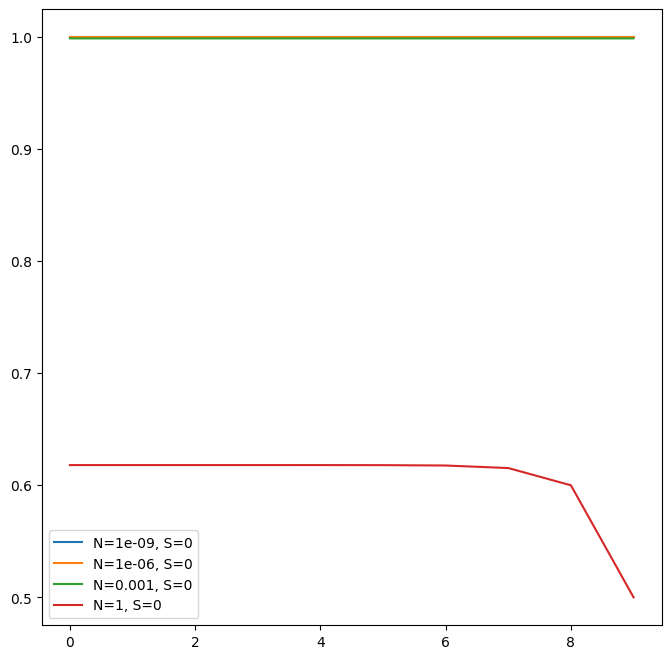

In [11]:
# plot them 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for i, N in enumerate(N_coefs):
    for j, S in enumerate(S_coefs):
        ax.plot(gains[i, j], label=f'N={N}, S={S}')
ax.legend()
plt.show()

# Initial exploration step with deterministic sampling

In [12]:
import scipy.linalg


def construct_control_model_inversion_estimate(x_series, control_series):
    assert len(x_series)-1 == len(control_series), (len(x_series), len(control_series))
    x_diff = np.hstack([x_series[idx] - x_series[idx-1] for idx in range(1, len(x_series))])
    U_partials = []
    for u in control_series:
        U_partial = np.array([u])
        U_partials.append(U_partial)
    U_partials = np.array(U_partials)
    U_tot = np.vstack(U_partials)
    x_diff = np.array(x_diff)
    # solve x_diff = U_tot * B
    return np.linalg.lstsq(U_tot, x_diff, rcond=None)

In [13]:
def sigma_points_from_covar(covar, alpha=1, kappa=0):
    n = covar.shape[0]
    lam = alpha**2 * (n + kappa) - n
    sigmas = np.zeros((2*n+1, n))
    sigmas[0] = np.zeros(n)
    sigmas[1:n+1] = np.linalg.cholesky((n + lam) * covar)
    sigmas[n+1:] = -sigmas[1:n+1]
    return sigmas

def control_model_exploration_strategy(covar, alpha=1, kappa=0):
    sigmas = sigma_points_from_covar(covar, alpha, kappa)
    n = covar.shape[0]
    us = []
    for i in range(n):
        us.append(sigmas[i+1])
        us.append(sigmas[n+i+1])
        us.append(sigmas[n+i+1])
        us.append(sigmas[i+1])
    return np.array(us)

In [14]:
M_final = np.eye(1)
M = np.eye(1)
N = 1e-3*np.eye(1)
S = 0*np.eye(1)

In [15]:
def make_estimate_from_error_state(x, num_shots_per_circ=512, depths=[2**i for i in range(8)], qid = 'Q1'):
    if type(x) is not float:
        x = x.flatten()[0]
    edesign = EDesign_Xoverrot(qids=[qid], depths=depths)
    model = create_XI_model_1q(np.array([x, 0, 0]), qid)
    ds = edesign.make_dataset(model, num_shots_per_circ)
    analysis = Analysis_Xoverrot(ds, edesign)
    return analysis.estimates['X overrot']

def step_error_state(x, u, B):
    return x + B * u

In [16]:
def make_initial_exploration_series(B, strategy, x0):
    x = x0
    xs = [np.array([[x]])]
    for u in strategy.flatten():
        x = step_error_state(x, u, B)
        xs.append(x)
    print(xs)
    return np.array(xs)

In [17]:
def make_control_covar_estimate(observations, B, controls):
    assert len(observations) == len(controls) + 1
    residuals = [observations[idx+1] - observations[i] for idx in range(len(controls))]
    n = len(controls)
    return (1/(n-1))*sum([(z - B*u)**2 for z, u in zip(observations, controls)])

In [18]:
num_shots = 512
depths = [2**i for i in range(8)]

x_true_initial = -0.001
B_true = (np.pi/np.sqrt(5))*np.eye(1)

x_covar_initial = 1e-5*np.eye(1)
initial_exploration_strategy = np.vstack([control_model_exploration_strategy(x_covar_initial, alpha=1, kappa=0)])
print(initial_exploration_strategy)


xhats_initial = [make_estimate_from_error_state(x_true_initial, num_shots, depths)]
xtrues = [x_true_initial]
x_step = x_true_initial
for u in initial_exploration_strategy:
    x_step = step_error_state(x_step, u, B_true)
    xhat = make_estimate_from_error_state(x_step, num_shots, depths)
    xtrues.append(x_step[0, 0])
    xhats_initial.append(xhat)
xhats_initial = np.array(xhats_initial)

print(len(xhats_initial))
B_estimate = construct_control_model_inversion_estimate(xhats_initial, initial_exploration_strategy)[0]
B_from_gt = construct_control_model_inversion_estimate(xtrues, initial_exploration_strategy)[0]
print('estimate', B_estimate)
print('estimate covar', make_control_covar_estimate(xhats_initial, B_estimate, initial_exploration_strategy))
print('true', B_true)
print('least squares from from true x', B_from_gt)
print('less squares from from true x covar', make_control_covar_estimate(xtrues, B_from_gt, initial_exploration_strategy))


[[ 0.00316228]
 [-0.00316228]
 [-0.00316228]
 [ 0.00316228]]
5
estimate [1.31301338]
estimate covar [5.99723529e-05]
true [[1.40496295]]
least squares from from true x [1.40496295]
less squares from from true x covar [6.7130696e-05]


In [19]:
initial_exploration_strategy

array([[ 0.00316228],
       [-0.00316228],
       [-0.00316228],
       [ 0.00316228]])

Text(0.5, 1.0, 'Initial deterministic exploration')

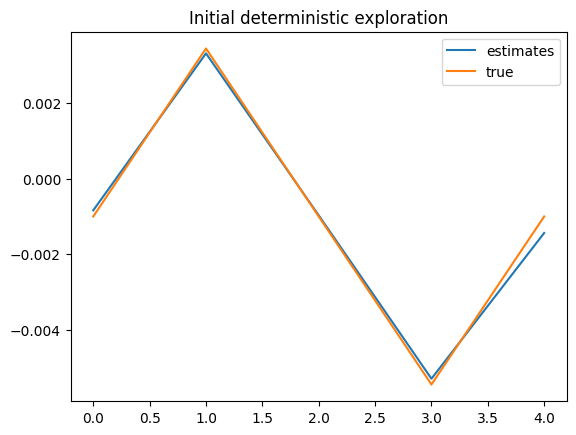

In [20]:
plt.plot(xhats_initial, label='estimates')
plt.plot(xtrues, label='true')
plt.legend()
plt.title('Initial deterministic exploration')

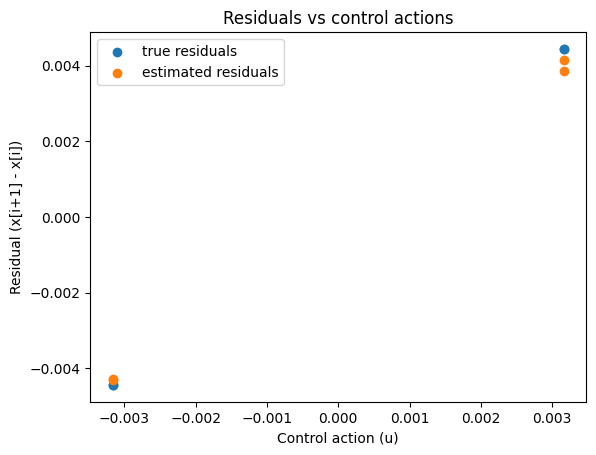

In [21]:
true_residuals = [xtrues[i+1] - xtrues[i] for i, x in enumerate(xtrues[:-1])]
estimated_residuals = [xhats_initial[i+1] - xhats_initial[i] for i, x in enumerate(xhats_initial[:-1])]
plt.scatter(initial_exploration_strategy, true_residuals, label='true residuals')
plt.scatter(initial_exploration_strategy, estimated_residuals, label='estimated residuals')
plt.title('Residuals vs control actions')
plt.xlabel('Control action (u)')
plt.ylabel('Residual (x[i+1] - x[i])')
plt.legend()

# Control model estimation with random exploration

In [22]:
num_shots = 512
depths = [2**i for i in range(8)]

x_true_initial = -0.00
B_true = (np.pi/np.sqrt(5))*np.eye(1)

x_covar_initial = 1e-5*np.eye(1)
random_strategy = np.random.normal(0, 0.01, (100, 1))


xhats_initial = [make_estimate_from_error_state(x_true_initial, num_shots, depths)]
xtrues = [x_true_initial]
x_step = x_true_initial
for u in random_strategy:
    x_step = step_error_state(x_step, u, B_true)
    xhat = make_estimate_from_error_state(x_step, num_shots, depths)
    xtrues.append(x_step[0, 0])
    xhats_initial.append(xhat)
xhats_initial = np.array(xhats_initial)

B_estimate = construct_control_model_inversion_estimate(xhats_initial, random_strategy)[0]
B_from_gt = construct_control_model_inversion_estimate(xtrues, random_strategy)[0]
print('estimate', B_estimate)
print('estimate covar', make_control_covar_estimate(xhats_initial, B_estimate, random_strategy))
print('true', B_true)
print('least squares from from true x', B_from_gt)
print('less squares from from true x covar', make_control_covar_estimate(xtrues, B_from_gt, random_strategy))

estimate [1.40982878]
estimate covar [0.00599084]
true [[1.40496295]]
least squares from from true x [1.40496295]
less squares from from true x covar [0.00594057]


In [23]:
2.216/1.45

1.5282758620689656

Text(0.5, 1.0, 'Error state trajectory')

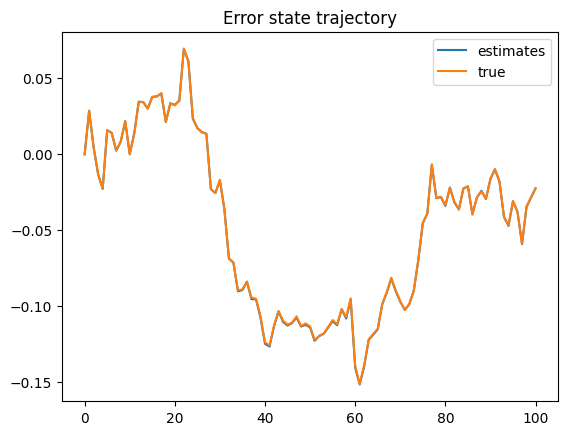

In [24]:
plt.plot(xhats_initial, label='estimates')
plt.plot(xtrues, label='true')
plt.legend()
plt.title('Error state trajectory')

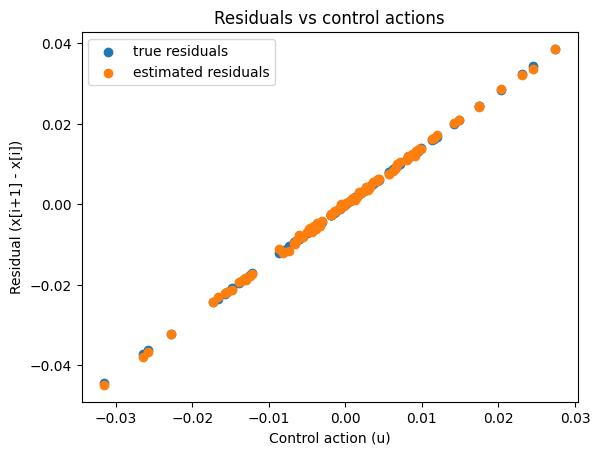

In [25]:
true_residuals = [xtrues[i+1] - xtrues[i] for i, x in enumerate(xtrues[:-1])]
estimated_residuals = [xhats_initial[i+1] - xhats_initial[i] for i, x in enumerate(xhats_initial[:-1])]
plt.scatter(random_strategy, true_residuals, label='true residuals')
plt.scatter(random_strategy, estimated_residuals, label='estimated residuals')
plt.title('Residuals vs control actions')
plt.xlabel('Control action (u)')
plt.ylabel('Residual (x[i+1] - x[i])')
plt.legend()

## Dual estimation 

In [26]:
def dual_kalman_gain(u, prior_covar, obs_covar, Q_add=0):
    P = prior_covar + Q_add
    D = u 
    R = obs_covar
    K = P * D.T /(D * P * D.T + R)
    return K

def dual_kalman_update(b, u, y, prior_covar, obs_covar, Q_add=0):
    K = dual_kalman_gain(u, prior_covar, obs_covar, Q_add)
    b_new = b + K * (y - u * b)
    P_new = (np.eye(prior_covar.shape[0]) - K * u) @ (prior_covar + Q_add)
    return b_new, P_new

In [27]:
print(B_true)
B0 = 0.01*np.eye(1)
P0 = 10*np.eye(1)
sigma_observation = np.pi/(depths[-1])

us = 0.1*np.random.randn(10)

x = x_true_initial
xhat0 = make_estimate_from_error_state(x, num_shots, depths)
xhats = [xhat0]
xtrues = [x]

Bs = [B0]
Ps = [P0]
for idx, u in enumerate(us):
    x = step_error_state(x, u, B_true)
    xtrues.append(x[0, 0])
    xhat = make_estimate_from_error_state(x, num_shots, depths)
    xhats.append(xhat)
    residual = xhats[idx+1] - xhats[idx]
    B, P = dual_kalman_update(Bs[-1], u, residual, Ps[-1], sigma_observation)
    Bs.append(B)
    Ps.append(P)
xhats = np.array(xhats)



[[1.40496295]]


Text(0.5, 1.0, 'Error state trajectory')

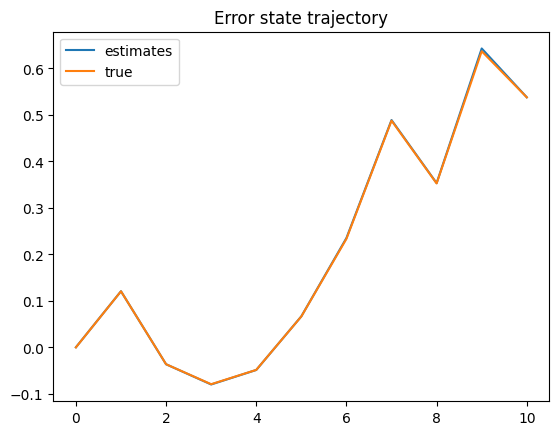

In [28]:
plt.plot(xhats, label='estimates')
plt.plot(xtrues, label='true')
plt.legend()
plt.title('Error state trajectory')


In [29]:
Bs

[array([[0.01]]),
 array([[1.0564161]]),
 array([[1.25268409]]),
 array([[1.25945888]]),
 array([[1.26274213]]),
 array([[1.29533312]]),
 array([[1.33407765]]),
 array([[1.36317574]]),
 array([[1.36843393]]),
 array([[1.38870788]]),
 array([[1.39248056]])]

In [30]:
Ps

[array([[10.]]),
 array([[2.49888735]]),
 array([[1.10165145]]),
 array([[1.05718752]]),
 array([[1.03572661]]),
 array([[0.80751595]]),
 array([[0.55136185]]),
 array([[0.31777579]]),
 array([[0.28385479]]),
 array([[0.19265769]]),
 array([[0.18541511]])]

In [31]:
B_true

array([[1.40496295]])

In [32]:
Bs = np.array([b[0, 0] for b in Bs])

In [33]:
Ps = np.array([p[0, 0] for p in Ps])

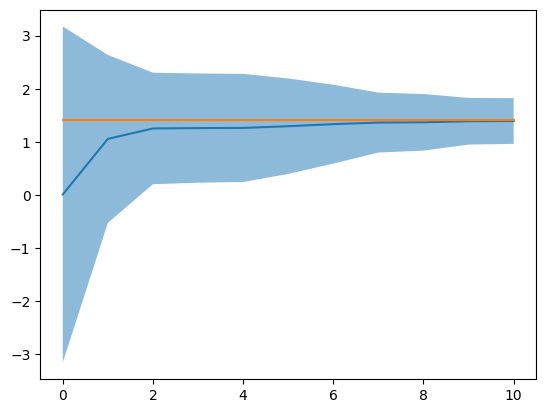

In [34]:
# plot the convergence of the dual kalman filter
plt.plot(Bs, label='B estimates')
plt.plot([B_true[0, 0]]*len(Bs), label='B true')
# plot 1std error bars
plt.fill_between(range(len(Bs)), [B - np.sqrt(P) for B, P in zip(Bs, Ps)], [B + np.sqrt(P) for B, P in zip(Bs, Ps)], alpha=0.5)

# Full algorithm with initial exploration

In [35]:
import numpy as np
from scipy.linalg import solve_discrete_are

def dlqr_1param(B, M, N):
  """
  Calculate the infinite horizon, discrete time LQR gain for a 1-parameter problem.

  Args:
    A: The state matrix (scalar).
    B: The input matrix (scalar).
    Q: The state cost matrix (scalar).
    R: The input cost matrix (scalar).

  Returns:
    The LQR gain (scalar).
  """

  # Solve the discrete-time algebraic Riccati equation (DARE)
  P = solve_discrete_are(1, B, M, N)

  # Calculate the LQR gain
  K = 1/(N + B**2 * P) * B * P

  return K

In [36]:
# initial exploration
num_shots = 512
depths = [2**i for i in range(8)]

x_true_initial = -0.001
B_true = (np.pi/np.sqrt(5))*np.eye(1)

x_covar_initial = 1e-5*np.eye(1)
initial_exploration_strategy = np.vstack([control_model_exploration_strategy(x_covar_initial, alpha=1, kappa=0)])
print(initial_exploration_strategy)


xhats_initial = [make_estimate_from_error_state(x_true_initial, num_shots, depths)]
xtrues = [x_true_initial]
x_step = x_true_initial
for u in initial_exploration_strategy:
    x_step = step_error_state(x_step, u, B_true)
    xhat = make_estimate_from_error_state(x_step, num_shots, depths)
    xtrues.append(x_step[0, 0])
    xhats_initial.append(xhat)
xhats_initial = np.array(xhats_initial)

print(len(xhats_initial))
B_estimate = construct_control_model_inversion_estimate(xhats_initial, initial_exploration_strategy)[0]
B_from_gt = construct_control_model_inversion_estimate(xtrues, initial_exploration_strategy)[0]
print('estimate', B_estimate)
print('estimate covar', make_control_covar_estimate(xhats_initial, B_estimate, initial_exploration_strategy))
print('true', B_true)
print('least squares from from true x', B_from_gt)
print('less squares from from true x covar', make_control_covar_estimate(xtrues, B_from_gt, initial_exploration_strategy))


[[ 0.00316228]
 [-0.00316228]
 [-0.00316228]
 [ 0.00316228]]
5
estimate [1.41566069]
estimate covar [6.84517187e-05]
true [[1.40496295]]
least squares from from true x [1.40496295]
less squares from from true x covar [6.7130696e-05]


In [37]:
P0

array([[10.]])

In [38]:
# control loop
print('Experiment with ground truth:')
print('B_true', B_true)
print('x0 true', x_true_initial)

print('===============================')

print('Initialization parameters:')
x0 = x_true_initial
B0 = B_estimate
P0 = make_control_covar_estimate(xhats_initial, B_estimate, initial_exploration_strategy)
print('B0', B0)
print('P0', P0)


max_depth_power = 8
depths = [2**i for i in range(max_depth_power)]
num_shots = 512
sigma_observation = np.pi/(depths[-1])
print('sigma_observation', sigma_observation)
delta_threshold = estimate_rpe_sigma(num_shots, max_depth_power)
print('delta threshold', delta_threshold)

N_lqr = 1/P0
print('N_lqr', N_lqr)
M_lqr = 1/sigma_observation
print('M_lqr', M_lqr)

# allocate the memory
xhats = [x0]
Bs = [B0*np.eye(1)]
Ps = [P0]
xtrues = [x0*np.eye(1)]
controls = []

# run the experiment
for k in range(1, 100):
    # calculate the lqr gain 
    G = dlqr_1param(Bs[k-1], M_lqr, N_lqr)
    # make the control
    u = -G * xhats[-1]
    controls.append(u)
    # make the true step
    x_step = step_error_state(xtrues[-1], u, B_true)
    xtrues.append(x_step)
    # make the observation
    xhat = make_estimate_from_error_state(x_step, num_shots, depths)
    xhats.append(xhat)
    # update the control model estimate
    B_new, P_new = dual_kalman_update(Bs[-1], u, xhat - xhats[-2], Ps[-1], sigma_observation, Q_add=1e-3)
    Bs.append(B_new)
    Ps.append(P_new)
Bs = np.array(Bs).flatten()
xtrues = np.array(xtrues).flatten()
xhats = np.array(xhats).flatten()
controls = np.array(controls).flatten()

Experiment with ground truth:
B_true [[1.40496295]]
x0 true -0.001
Initialization parameters:
B0 [1.41566069]
P0 [6.84517187e-05]
sigma_observation 0.02454369260617026
delta threshold 0.00027117205433095496
N_lqr [14608.83699603]
M_lqr 40.74366543152521


# Full algorithm without initial exploration

In [39]:
# control loop
x_true_initial = 0.1
print('Experiment with ground truth:')
print('B_true', B_true)
print('x0 true', x_true_initial)

print('===============================')

print('Initialization parameters:')
x0 = x_true_initial
B0 = -1*np.eye(1)
P0 = 10*np.eye(1)
print('B0', B0)
print('P0', P0)


max_depth_power = 8
depths = [2**i for i in range(max_depth_power)]
num_shots = 512
sigma_observation = np.pi/(depths[-1])
print('sigma_observation', sigma_observation)
delta_threshold = estimate_rpe_sigma(num_shots, max_depth_power)
print('delta threshold', delta_threshold)


M_lqr = 1/sigma_observation
print('M_lqr', M_lqr)

# allocate the memory
xhats = [x0]
Bs = [B0*np.eye(1)]
Ps = [P0]
xtrues = [x0*np.eye(1)]
controls = []
stopping_index = -1


# run the experiment
for k in range(1, 10):
    # calculate the lqr gain 
    N_lqr = 1e-3*P0
    G = dlqr_1param(Bs[k-1], M_lqr, N_lqr)
    # make the control
    u = -G * xhats[-1]
    controls.append(u)
    # make the true step
    x_step = step_error_state(xtrues[-1], u, B_true)
    xtrues.append(x_step)
    # make the observation
    xhat = make_estimate_from_error_state(x_step, num_shots, depths)
    xhats.append(xhat)
    if np.abs(xhat) < delta_threshold and stopping_index == -1:
        stopping_index = k
    # update the control model estimate
    B_new, P_new = dual_kalman_update(Bs[-1], u, xhat - xhats[-2], Ps[-1], sigma_observation, Q_add=1e-3)
    Bs.append(B_new)
    Ps.append(P_new)
Bs = np.array(Bs).flatten()
xtrues = np.array(xtrues).flatten()
xhats = np.array(xhats).flatten()
controls = np.array(controls).flatten()
Ps = np.array(Ps).flatten()

Experiment with ground truth:
B_true [[1.40496295]]
x0 true 0.1
Initialization parameters:
B0 [[-1.]]
P0 [[10.]]
sigma_observation 0.02454369260617026
delta threshold 0.00027117205433095496
M_lqr 40.74366543152521


In [40]:
stopping_index

-1

Text(0.5, 1.0, 'Error state trajectory')

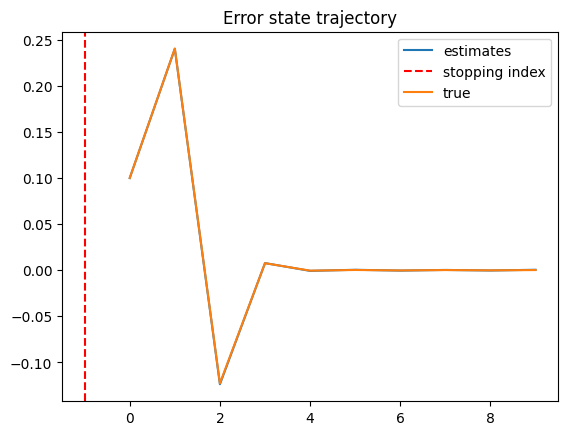

In [41]:
# plot the evolution of the error state
plt.plot(xhats, label='estimates')
error_state_uncertainty = estimate_rpe_sigma(512, 8)
# plot the error bars for the estimates
plt.fill_between(range(len(xhats)), xhats - error_state_uncertainty, xhats + error_state_uncertainty, alpha=0.5)
# plot a vertical line for the stopping index
plt.axvline(stopping_index, color='red', linestyle='--', label='stopping index')
plt.plot(xtrues, label='true')
plt.legend()
plt.title('Error state trajectory')


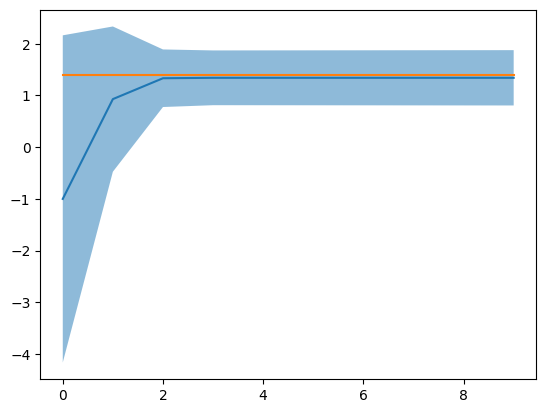

In [42]:
# plot the evolution of the control model
plt.plot(Bs, label='B estimates')
plt.plot([B_true[0, 0]]*len(Bs), label='B true')
# plot 1std error bars
plt.fill_between(range(len(Bs)), Bs - np.sqrt(Ps), Bs + np.sqrt(Ps), alpha=0.5)

# Testing trajectories for the full algorithm

## First with a very far off estimate of B

In [43]:
def run_algorithm(x_true_initial, B_initial, P_initial, B_true=np.pi/np.sqrt(5), num_shots=512, max_depth_power=8, max_iters=25, verbose=False):
    # control loop
    if verbose:
        print('Experiment with ground truth:')
        print('B_true', B_true)
        print('x0 true', x_true_initial)

        print('===============================')

        print('Initialization parameters:')
    x0 = x_true_initial
    B0 = B_initial*np.eye(1)
    P0 = P_initial*np.eye(1)
    if verbose:
        print('B0', B0)
        print('P0', P0)


    max_depth_power = 8
    depths = [2**i for i in range(max_depth_power)]
    num_shots = 512
    sigma_observation = np.pi/(depths[-1])
    
    delta_threshold = estimate_rpe_sigma(num_shots, max_depth_power)
    if verbose:
        print('delta threshold', delta_threshold)
        print('sigma_observation', sigma_observation)

    
    M_lqr = 1/sigma_observation

    if verbose:
        print('M_lqr', M_lqr)

    # allocate the memory
    xhats = [x0]
    Bs = [B0*np.eye(1)]
    Ps = [P0]
    xtrues = [x0*np.eye(1)]
    controls = []
    stopping_index = -1


    # run the experiment
    for k in range(1, max_iters):
        # calculate the lqr gain 
        N_lqr = Ps[-1]
        G = dlqr_1param(Bs[k-1], M_lqr, N_lqr)
        # make the control
        u = -G * xhats[-1]
        controls.append(u)
        # make the true step
        x_step = step_error_state(xtrues[-1], u, B_true)
        xtrues.append(x_step)
        # make the observation
        xhat = make_estimate_from_error_state(x_step, num_shots, depths)
        xhats.append(xhat)
        if np.abs(xhat) < delta_threshold and stopping_index == -1:
            stopping_index = k
        # update the control model estimate
        B_new, P_new = dual_kalman_update(Bs[-1], u, xhat - xhats[-2], Ps[-1], sigma_observation, Q_add=1e-3)
        Bs.append(B_new)
        Ps.append(P_new)
    Bs = np.array(Bs).flatten()
    xtrues = np.array(xtrues).flatten()
    xhats = np.array(xhats).flatten()
    controls = np.array(controls).flatten()
    Ps = np.array(Ps).flatten()
    return xhats, xtrues, Bs, Ps, controls, stopping_index

In [44]:
xhats, xtrues, Bs, Ps, controls, stopping_index = run_algorithm(0.1, -1, 10, verbose=True)

Experiment with ground truth:
B_true 1.4049629462081452
x0 true 0.1
Initialization parameters:
B0 [[-1.]]
P0 [[10.]]
delta threshold 0.00027117205433095496
sigma_observation 0.02454369260617026
M_lqr 40.74366543152521


In [69]:
# run the algorithm with 100 different x0's
num_trials = 1000
x0s = np.random.normal(0, 0.01, num_trials)
B0 = 1
P0 = 10
results = []
for x0 in tqdm(x0s):
    xhats, xtrues, Bs, Ps, controls, stopping_index = run_algorithm(x0, B0, P0)
    results.append({'xhats': xhats, 'xtrues': xtrues, 'Bs': Bs, 'Ps': Ps, 'controls': controls, 'stopping_index': stopping_index})

100%|██████████| 1000/1000 [02:19<00:00,  7.16it/s]


In [65]:
all_xhats = np.array([result['xhats'] for result in results])
all_xtrues = np.array([result['xtrues'] for result in results])
all_Bs = np.array([result['Bs'] for result in results])
all_Ps = np.array([result['Ps'] for result in results])
all_controls = np.array([result['controls'] for result in results])
all_stopping_indices = np.array([result['stopping_index'] for result in results])

Text(0, 0.5, 'Error state')

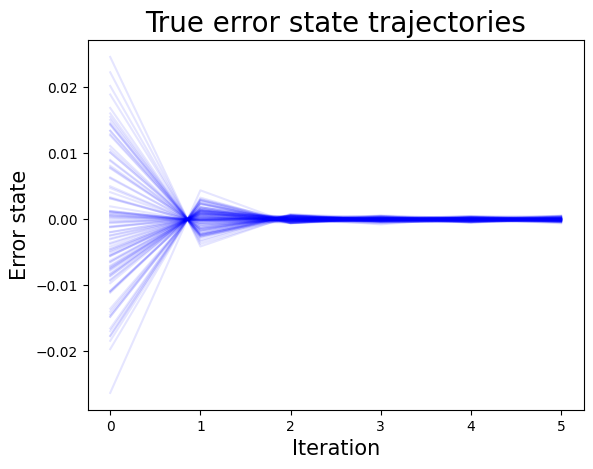

In [84]:
plt.plot(all_xtrues.T[0:6], color='blue', alpha=0.1);
plt.title('True error state trajectories', fontsize=20)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Error state', fontsize=15)

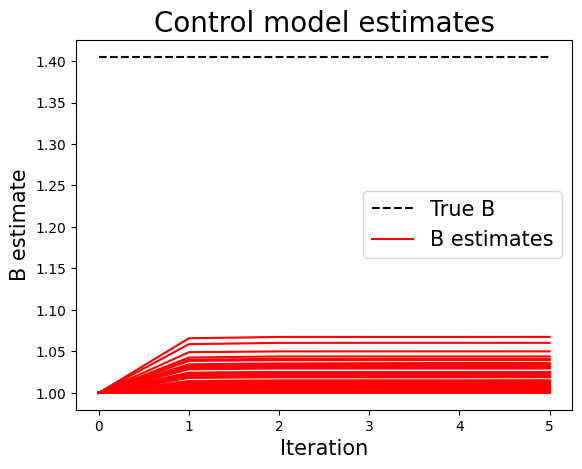

In [82]:
plt.plot([np.pi/np.sqrt(5)]*6, color='black', linestyle='--')
plt.plot(all_Bs.T[0:6], color='red');
# plot the true B

# use large text
plt.title('Control model estimates', fontsize=20)

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('B estimate', fontsize=15)
plt.legend(['True B', 'B estimates'], fontsize=15)


Text(0, 0.5, 'Frequency')

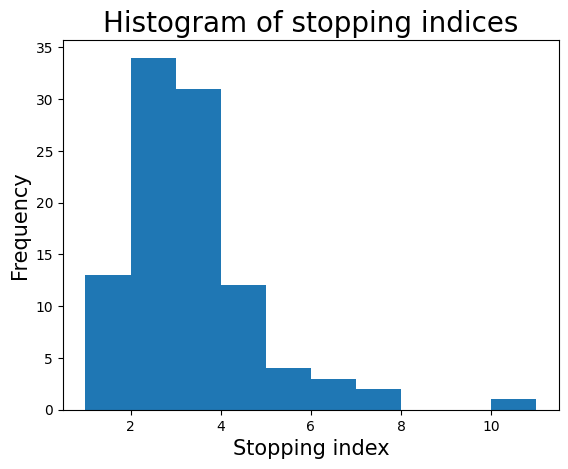

In [83]:
plt.hist(all_stopping_indices)
plt.title('Histogram of stopping indices', fontsize=20)
plt.xlabel('Stopping index', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

## Now with a poor initial guess of B

In [76]:
# run the algorithm with 100 different x0's
num_trials = 1000
x0s = np.random.normal(0, 0.01, num_trials)
B0 = -0.3
P0 = 1
results = []
for x0 in tqdm(x0s):
    xhats, xtrues, Bs, Ps, controls, stopping_index = run_algorithm(x0, B0, P0)
    results.append({'xhats': xhats, 'xtrues': xtrues, 'Bs': Bs, 'Ps': Ps, 'controls': controls, 'stopping_index': stopping_index})

100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


In [77]:
def plot_xtrue_traj(results):
    x_true = np.array([result['xtrues'] for result in results])
    plt.plot(x_true.T, color='blue', alpha=0.1);
    plt.title('True error state trajectories')
    plt.xlabel('Iteration')
    plt.ylabel('Error state')


def plot_B_estimates(results):
    B_estimates = np.array([result['Bs'] for result in results])
    plt.plot(B_estimates.T, color='red', alpha=0.1);
    plt.title('Control model estimates')
    plt.xlabel('Iteration')
    plt.ylabel('B estimate')

def plot_stopping_indices(results):
    stopping_indices = np.array([result['stopping_index'] for result in results])
    plt.hist(stopping_indices)
    plt.title('Histogram of stopping indices')
    plt.xlabel('Stopping index')
    plt.ylabel('Frequency')

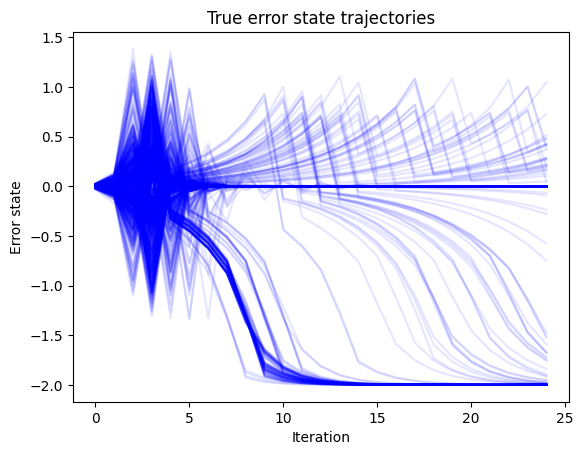

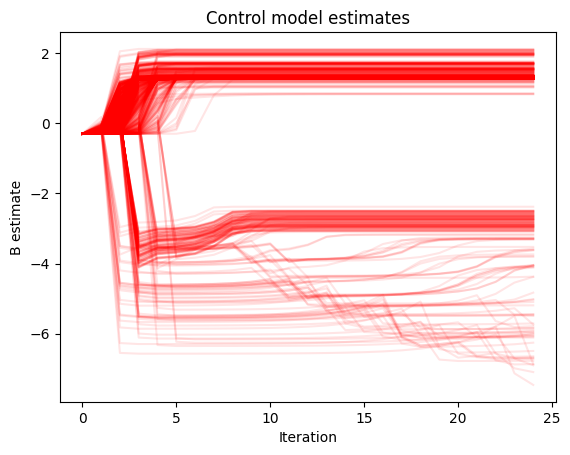

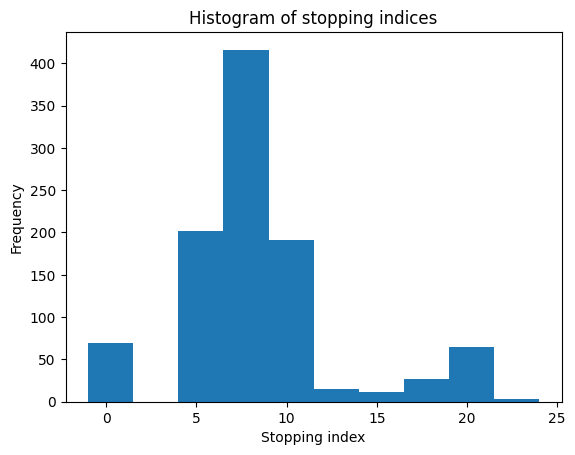

In [78]:
plot_xtrue_traj(results)
plt.figure()
plot_B_estimates(results)
plt.figure()
plot_stopping_indices(results)